In [1]:
import numpy as np
import pandas as pd
%pylab inline
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Helper functions for calculating PCA 

### Rescaling feature vectors to all have the same scale

In [2]:
from sklearn.preprocessing import StandardScaler

def rescale_features(data):
    """
    CA is effected by scale so we need to scale the features to help in standardize the dataset’s 
    features onto unit scale (mean = 0 and variance = 1) 
    """
    # Separating out the features
    x = data.loc[:, :].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    
    data_out = pd.DataFrame(x)
    data_out.columns = data.columns.values
    return data_out

###  Calculate the mean of all m variables as a single vector in Rm

In [3]:
def calc_mean(data,features,M):
    mean_vector = np.zeros(shape=(M,1))
    for i in range(M):
        curr = features[i]
        mu = np.mean(data.loc[curr])
        mean_vector[i,0]=mu
    return mean_vector

###  Computing the Scatter Matrix

In [4]:
def scatter(data,features,N,M,mean_vector):
    scatter_matrix = np.zeros((M,M))
    for i in range(N):
        # re-center the data so that the mean is zero by substracting data with the mean. 
        B = (((data.loc[:,i]).values).reshape(M,1)) - mean_vector
        scatter_matrix += B.dot((B.T))
    return(scatter_matrix)    

###  Sorting the eigenvectors

In [5]:
def sort_eign(data,eig_vec_cov,eig_val_cov):
    '''
    Look at the corresponding eigenvalues of the eigenvectors. 
    The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue 
    and choose the top k eigenvectors.
    '''
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    #eig_pairs.sort(key=lambda x: x[0], reverse=True)

    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    #for i in eig_pairs:
    #    print(i[0])
    
    return eig_pairs
    

###  Choosing k eigenvectors with the largest eigenvalues

In [6]:
def get_k_eign(eig_pairs,M,k):
    k_list = []
    for i in range(k):
        k_list.append((eig_pairs[i][1]).reshape(M,1))
    matrix_w = np.hstack(k_list)
    #print('Matrix W:\n', matrix_w)
    return matrix_w

# PCA

In [7]:
def pca(data,k):
    """
        input: Data and k-values for dimension reduction
    """
    # Number of records
    N = data.shape[0]
    ## Number of features
    M = data.shape[1]
    # Extract features
    features = list(data.columns)
    #print("Data has {records} records while {features} features".format(records=N,features=M))
    #print('-'*40)
    
    # Scale_data 
    #data=rescale_features(data)

    # Get Transpose of Data.
    data = data.T
    #print(data)

    # Calculate mean vector out of features 
    mean_vector = calc_mean(data,features,M)
    #print('Mean Vector:\n', mean_vector)
    #print('-'*40)

    #Calculate Scatter Matrix
    scatter_mat =  scatter(data,features,N,M,mean_vector)
    #print('Scatter Matrix:\n', scatter_mat)
    #print('-'*40)
    
    # Calculate covariancee from scatter Matrix
    cov_mat = (1/(N-1))*scatter_mat
    #print('Covariance Matrix:\n', cov_mat)
    #print('-'*40)
    
    # eigenvectors and eigenvalues for the from the covariance matrix
    eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
    
    # check that the eigenvector-eigenvalue calculation is correct and satisfy the equation
    for i in range(len(eig_val_cov)):
        eigv = eig_vec_cov[:,i].reshape(1,M).T
        np.testing.assert_array_almost_equal(cov_mat.dot(eigv), eig_val_cov[i] * eigv,
                                             decimal=6, err_msg='', verbose=True)
    
    # All eignvectors have same unit length 1 in which define the directions of the new axis 
    for ev in eig_vec_cov:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
        
    # Sorting the eigenvectors by decreasing eigenvalues
    eig_pairs = sort_eign(data,eig_vec_cov,eig_val_cov)
    
    # Choose top k eigenvectors.
    matrix_w= get_k_eign(eig_pairs,M,k)
    
    transformed = matrix_w.T.dot(data)
    
    
    return matrix_w,transformed
    
    #return data

In [8]:
data_df = pd.read_csv('Data.txt', sep=" ", header=None)
data_df.columns = ["feature1", "feature2"]

In [9]:
data_df.head()

,feature1,feature2
0,4.309901,4.174589
1,4.500796,3.604371
2,4.564716,5.748079
3,6.765445,6.245457
4,4.733802,5.446039


In [10]:
data_df.shape

(1000, 2)

In [11]:
eign_vec, principalComponents = pca(data_df,2)

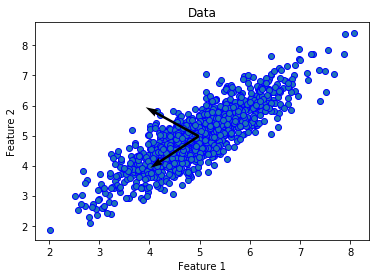

In [15]:
plt.scatter(data_df['feature1'], data_df['feature2'], edgecolors='b')

origin = [data_df['feature1'].mean()], [data_df['feature2'].mean()]

plt.quiver(*origin ,eign_vec[0],eign_vec[1],units="xy",angles='xy', scale_units='xy', scale=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data')
plt.savefig('Data_PCA.png')
plt.show()